# 1. Loan Payment Data Preparation

### 1.1 Read data from excel file: Loan payments data.xlsx

In [1]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile

DATA_DIR = 'Data'
DATA_FILE = DATA_DIR + '/Loan payments data.xlsx'

df = pd.read_excel(DATA_FILE, sheet_name='Sheet1', dtype={'past_due_days': np.float64})


### 1.2 Preview data table definition and data

In [2]:
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
Loan_ID           500 non-null object
loan_status       500 non-null object
Principal         500 non-null int64
terms             500 non-null int64
effective_date    500 non-null datetime64[ns]
due_date          500 non-null datetime64[ns]
paid_off_time     400 non-null datetime64[ns]
past_due_days     200 non-null float64
age               500 non-null int64
education         500 non-null object
Gender            500 non-null object
dtypes: datetime64[ns](3), float64(1), int64(3), object(4)
memory usage: 43.0+ KB


,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-09-14 19:31:01,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-10-07 09:00:00,NaN,50,Bechalor,female
2,xqd20160003,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-09-25 16:58:04,NaN,33,Bechalor,female
3,xqd20160004,PAIDOFF,1000,15,2016-09-08,2016-09-22,2016-09-22 20:00:58,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,2016-09-09,2016-10-08,2016-09-23 21:36:56,NaN,28,college,female


# 2. Data cleanup
### 2.1 check data summary

In [3]:
clean_df = df.copy()
clean_df.describe()

,Principal,terms,past_due_days,age
count,500.000000,500.000000,200.00000,500.000000
mean,943.200000,22.824000,36.01000,31.116000
std,115.240274,8.000064,29.38088,6.084784
min,300.000000,7.000000,1.00000,18.000000
25%,1000.000000,15.000000,3.00000,27.000000
50%,1000.000000,30.000000,37.00000,30.000000
75%,1000.000000,30.000000,60.00000,35.000000
max,1000.000000,30.000000,76.00000,51.000000


In [4]:
clean_df['loan_status'].value_counts() / len(clean_df)

PAIDOFF               0.6
COLLECTION_PAIDOFF    0.2
COLLECTION            0.2
Name: loan_status, dtype: float64

In [5]:
clean_df['Gender'].value_counts() / len(clean_df)

male      0.846
female    0.154
Name: Gender, dtype: float64

In [6]:
clean_df['education'].value_counts() / len(clean_df)

college                 0.440
High School or Below    0.418
Bechalor                0.134
Master or Above         0.008
Name: education, dtype: float64

### 2.2 Fill NaN (null value) in past_due_days field

In [7]:
clean_df['paid_off_date'] = clean_df['paid_off_time'].dt.normalize()   
clean_df.loc[clean_df['past_due_days'].isnull(),'past_due_days'] = (clean_df['paid_off_date'] - clean_df['due_date'])/np.timedelta64(1,'D')

clean_df.drop('paid_off_date', axis=1, inplace=True)

### 2.3 Add data range for age and past_due_days

In [8]:
min_age = clean_df['age'].min()
max_age = clean_df['age'].max()
age_ranges = ["[{0} - {1})".format(age, age + 5) for age in range(min_age -3, max_age +3, 5)]
count_unique_age_ranges = len(age_ranges)

clean_df['age_range'] = pd.cut(x=clean_df['age'], bins=count_unique_age_ranges, labels=age_ranges)

In [9]:
min_days = clean_df['past_due_days'].min()
max_days = clean_df['past_due_days'].max()
days_ranges = ["[{0} - {1})".format(days, days + 10) for days in range(np.int64(min_days) -3, np.int64(max_days) +3, 10)]
count_unique_days_ranges = len(days_ranges)

clean_df['past_due_days_range'] = pd.cut(x=clean_df['past_due_days'], bins=count_unique_days_ranges, labels=days_ranges)

In [10]:
clean_df['due_date_Weekday'] = clean_df['due_date'].dt.dayofweek

d = ["Morning", "Afternoon", "Evening", "Night"]
dnum = [1, 2, 3, 4]
periods = [0.0, 21600.0, 43200.0, 64800.0, 86400.0] 

clean_df[['hour','minute','second']] = pd.to_timedelta(clean_df['paid_off_time']).dt.components.iloc[:, 1:4]
clean_df["paid_off_Sec"] = clean_df['hour']*3600 + clean_df['minute']*60 + clean_df['second']
clean_df["paid_off_Period"] = pd.cut(clean_df["paid_off_Sec"], periods, labels=d)
clean_df["paid_off_PeriodTran"] = pd.cut(clean_df["paid_off_Sec"], periods, labels=dnum)

clean_df.drop('paid_off_Sec', axis=1, inplace=True)
clean_df.drop('hour', axis=1, inplace=True)
clean_df.drop('minute', axis=1, inplace=True)
clean_df.drop('second', axis=1, inplace=True)

### 2.4 check data after data cleanup

In [11]:
clean_df.head()

,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender,age_range,past_due_days_range,due_date_Weekday,paid_off_Period,paid_off_PeriodTran
0,xqd20166231,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-09-14 19:31:01,-23.0,45,High School or Below,male,[45 - 50),[-31 - -21),4,Night,4
1,xqd20168902,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-10-07 09:00:00,0.0,50,Bechalor,female,[50 - 55),[-11 - -1),4,Afternoon,2
2,xqd20160003,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-09-25 16:58:04,-12.0,33,Bechalor,female,[30 - 35),[-21 - -11),4,Evening,3
3,xqd20160004,PAIDOFF,1000,15,2016-09-08,2016-09-22,2016-09-22 20:00:58,0.0,27,college,male,[25 - 30),[-11 - -1),3,Night,4
4,xqd20160005,PAIDOFF,1000,30,2016-09-09,2016-10-08,2016-09-23 21:36:56,-15.0,28,college,female,[25 - 30),[-21 - -11),5,Night,4


In [12]:
clean_df.describe()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
Loan_ID                500 non-null object
loan_status            500 non-null object
Principal              500 non-null int64
terms                  500 non-null int64
effective_date         500 non-null datetime64[ns]
due_date               500 non-null datetime64[ns]
paid_off_time          400 non-null datetime64[ns]
past_due_days          500 non-null float64
age                    500 non-null int64
education              500 non-null object
Gender                 500 non-null object
age_range              500 non-null category
past_due_days_range    500 non-null category
due_date_Weekday       500 non-null int64
paid_off_Period        400 non-null category
paid_off_PeriodTran    400 non-null category
dtypes: category(4), datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 50.1+ KB


# 3. Exploratory Data Analysis

Plot the 'loan_status' variable against other variables. 

### 3.0 Check all relationship

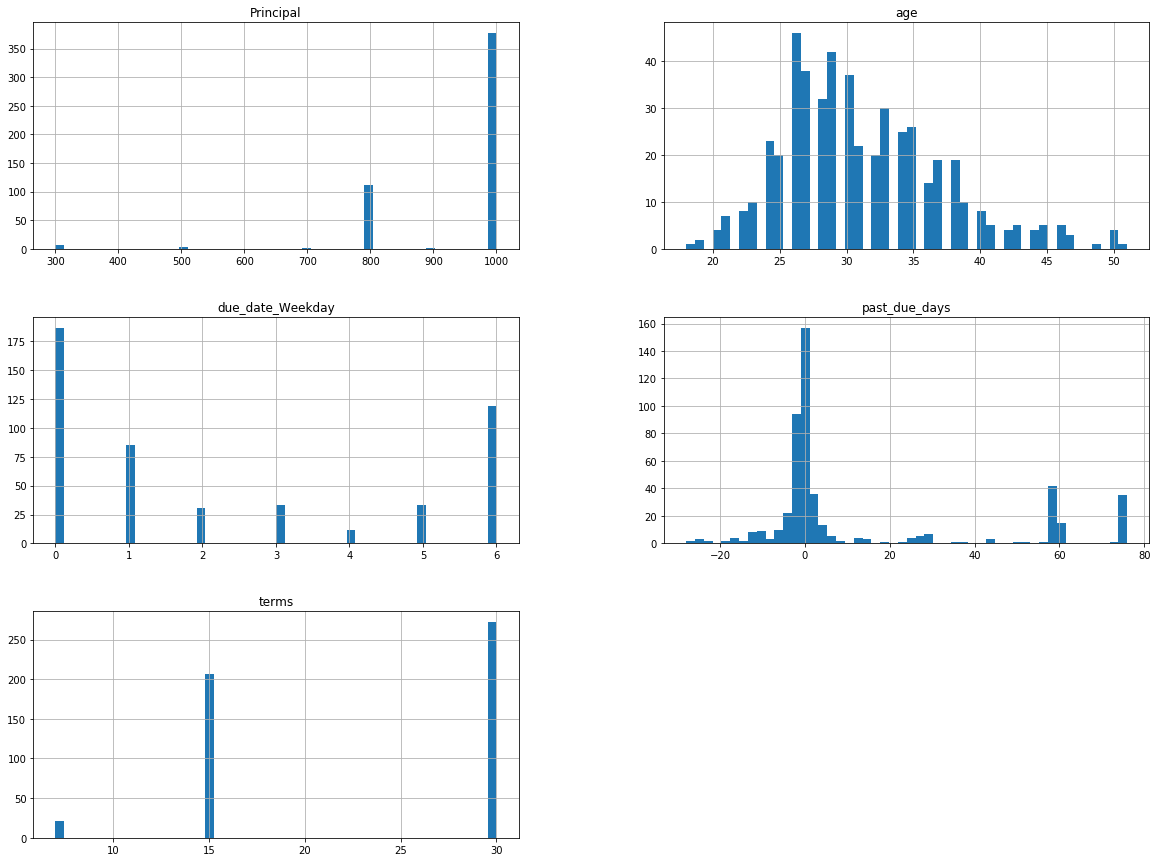

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
clean_df.hist(bins=50, figsize=(20,15))
plt.show()

In [35]:
# how about the other variables
columns = ['loan_status', 'age', 'past_due_days', 'terms',
           'Principal', 'paid_off_PeriodTran','due_date_Weekday']
clean_df[columns].groupby('loan_status').mean()

,age,past_due_days,terms,Principal,due_date_Weekday
loan_status,,,,,
COLLECTION,30.61,62.860000,23.850000,954.0,3.00
COLLECTION_PAIDOFF,31.34,9.160000,23.920000,957.0,1.86
PAIDOFF,31.21,-2.853333,22.116667,935.0,2.29


### 3.1 Is there a difference in the loan status based on gender?

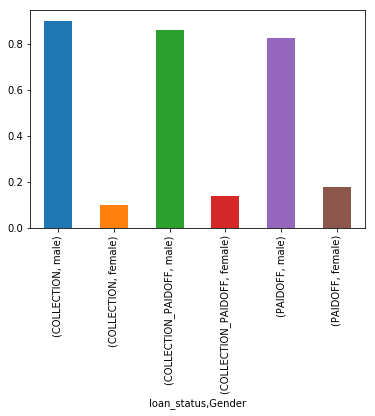

In [14]:
%matplotlib inline
from helpers import *

clean_df.groupby('loan_status')['Gender'].value_counts(normalize=True).plot.bar()

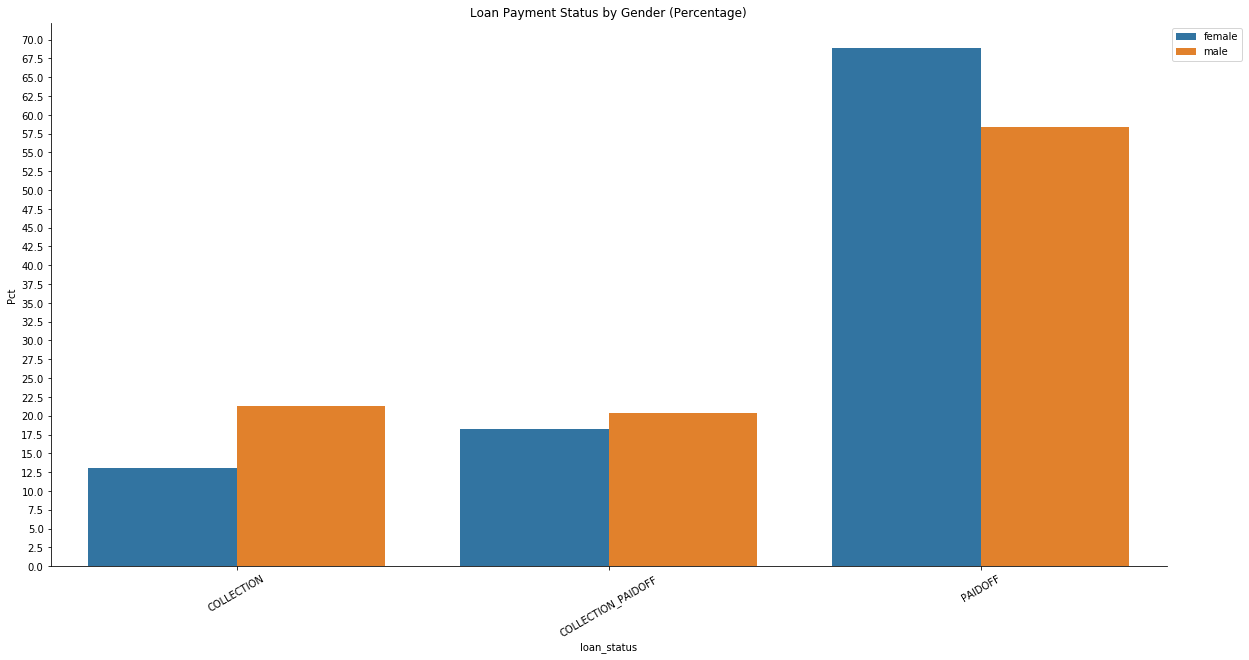

In [15]:
gender_df = clean_df.groupby(['loan_status','Gender']).size().reset_index(name='counts')
gender_sum = gender_df.groupby(['Gender','loan_status',]).agg({'counts': 'sum'})
gender_pcts = gender_sum.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
gender_pcts.rename({'counts': 'Pct'}, axis=1, inplace=True)

ShowBarPlot(data=gender_pcts, x='loan_status',y='Pct',hue='Gender',bins=30, 
           title='Loan Payment Status by Gender (Percentage)',
           rotation=30,figsize_x=20, figsize_y=10)

#### Conclusion for Gender vs. Loan Payment Status Relationship
- Male is more likely to borrow loan than Female
- Female is more like to pay off the loan than Male


### 3.2. Is there a difference in the age distribution between loan status?

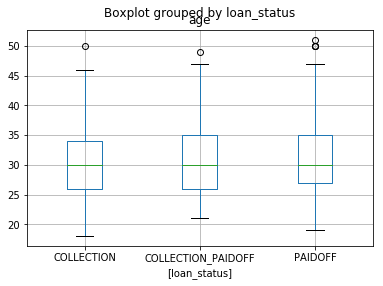

In [16]:
clean_df[['age','loan_status']].boxplot(by='loan_status')

In [17]:
age_df = clean_df.groupby(['loan_status','age']).size().reset_index(name='counts')

min_age = age_df['age'].min()
max_age = age_df['age'].max()
age_ranges = ["[{0} - {1})".format(age, age + 5) for age in range(min_age -3, max_age +3, 5)]
count_unique_age_ranges = len(age_ranges)

In [18]:
age_df['age_range'] = pd.cut(x=age_df['age'], bins=count_unique_age_ranges, labels=age_ranges)
age_range_df = age_df.groupby(['loan_status','age_range']).size().reset_index(name='agen_range_counts')

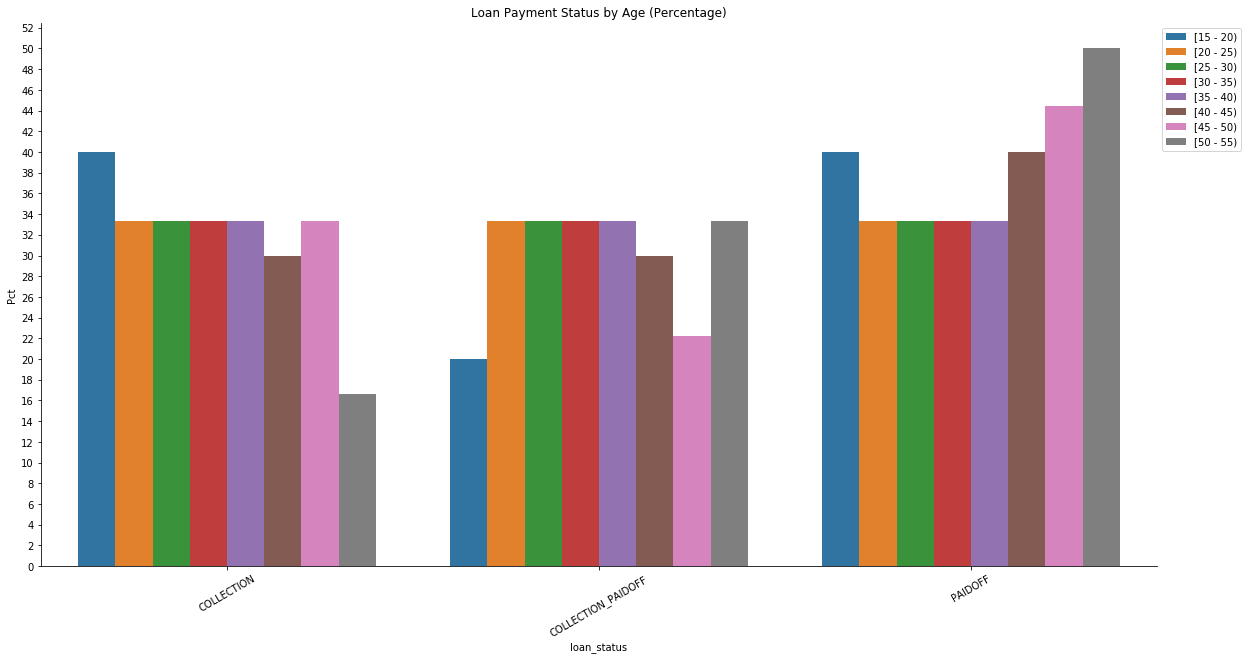

In [19]:
age_sum = age_range_df.groupby(['age_range','loan_status']).agg({'agen_range_counts': 'sum'})
age_pcts = age_sum.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
age_pcts.rename({'agen_range_counts': 'Pct'}, axis=1, inplace=True)

ShowBarPlot(data=age_pcts, x='loan_status',y='Pct',hue='age_range',bins=30, 
           title='Loan Payment Status by Age (Percentage)',
           rotation=30,figsize_x=20, figsize_y=10)

#### Conclusion for Age vs. Loan Payment Status Relationship
- Older people is more likely to payoff loan (age range is 40 - 55)
- Age between 20 and 40 doesn't make any difference on loan payment status
- People is younger than 20, loan status is either pay off or collection.


### 3.3 Is there a difference in the loan status based on Principal?

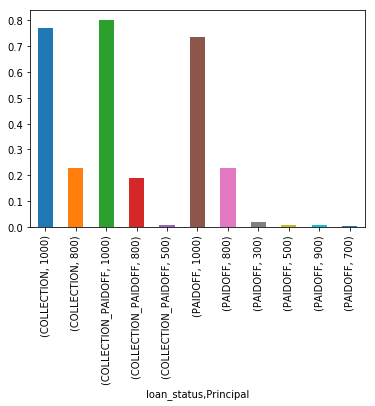

In [20]:
clean_df.groupby('loan_status')['Principal'].value_counts(normalize=True).plot.bar()

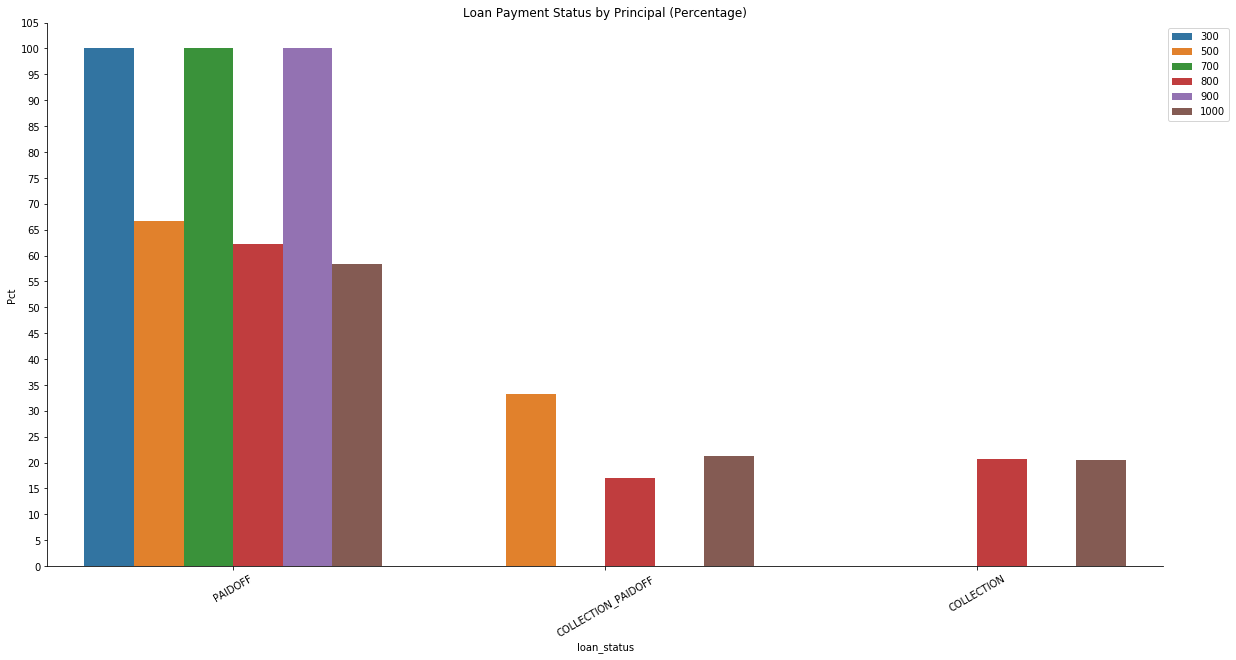

In [21]:
Principal_df = clean_df.groupby(['loan_status','Principal']).size().reset_index(name='counts')
Principal_sum = Principal_df.groupby(['Principal','loan_status',]).agg({'counts': 'sum'})
Principal_pcts = Principal_sum.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
Principal_pcts.rename({'counts': 'Pct'}, axis=1, inplace=True)

ShowBarPlot(data=Principal_pcts, x='loan_status',y='Pct',hue='Principal',bins=30, 
           title='Loan Payment Status by Principal (Percentage)',
           rotation=30,figsize_x=20, figsize_y=10)

In [22]:
Principal_pcts.head(100)

,Principal,loan_status,Pct
0,300,PAIDOFF,100.000000
1,500,COLLECTION_PAIDOFF,33.333333
2,500,PAIDOFF,66.666667
3,700,PAIDOFF,100.000000
4,800,COLLECTION,20.720721
5,800,COLLECTION_PAIDOFF,17.117117
6,800,PAIDOFF,62.162162
7,900,PAIDOFF,100.000000
8,1000,COLLECTION,20.424403
9,1000,COLLECTION_PAIDOFF,21.220159


#### Conclusion for Principal vs. Loan Payment Status Relationship
- people is more likely to payoff small loans (the cut off amount from this data set is 800-900). But this data set size is too small to make this conclusion.
- For 1000 principal loan, there is higher chance that borrower missed the due date.

### 3.4 Is there a difference in the loan status based on Education?

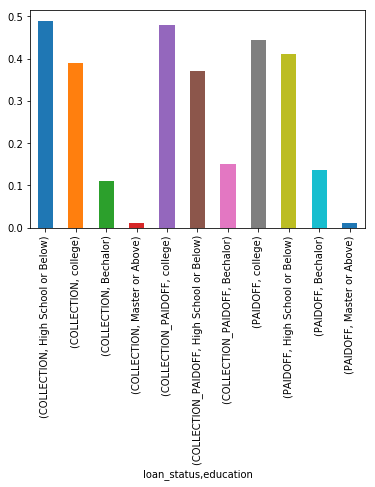

In [23]:
clean_df.groupby('loan_status')['education'].value_counts(normalize=True).plot.bar()

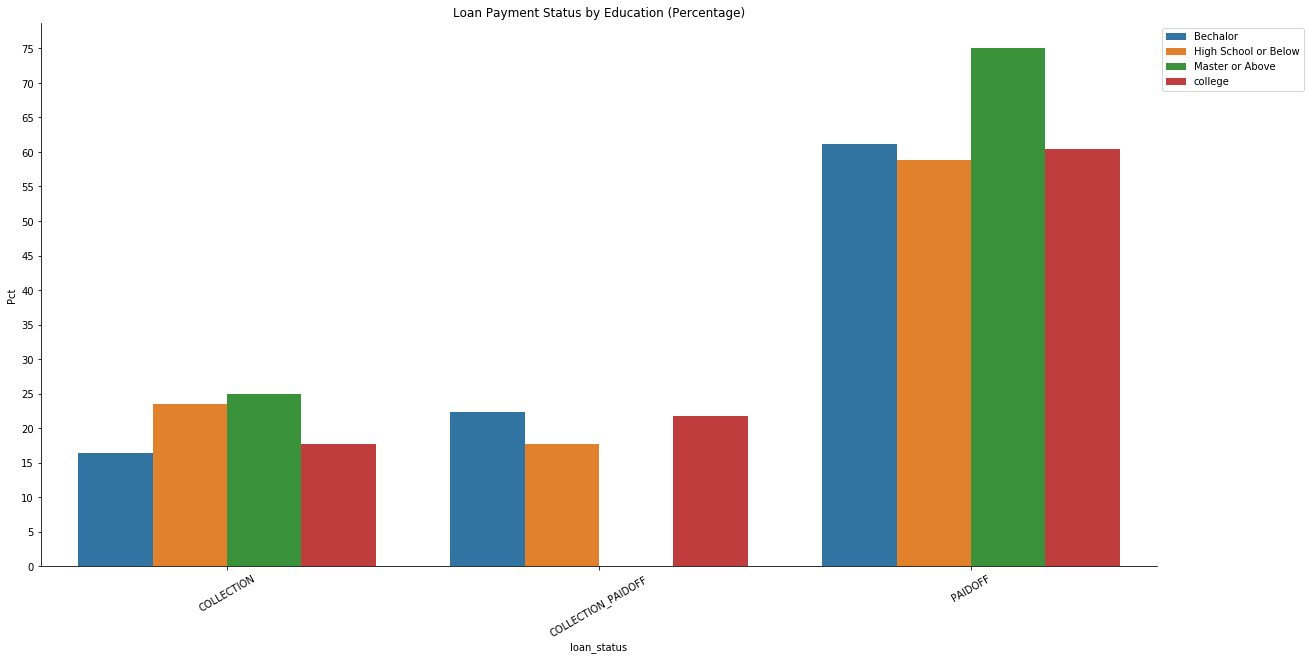

In [24]:
education_df = clean_df.groupby(['loan_status','education']).size().reset_index(name='counts')
education_sum = education_df.groupby(['education','loan_status',]).agg({'counts': 'sum'})
education_pcts = education_sum.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
education_pcts.rename({'counts': 'Pct'}, axis=1, inplace=True)

ShowBarPlot(data=education_pcts, x='loan_status',y='Pct',hue='education',bins=30, 
           title='Loan Payment Status by Education (Percentage)',
           rotation=30,figsize_x=20, figsize_y=10)

In [25]:
education_pcts.head(100)

,education,loan_status,Pct
0,Bechalor,COLLECTION,16.417910
1,Bechalor,COLLECTION_PAIDOFF,22.388060
2,Bechalor,PAIDOFF,61.194030
3,High School or Below,COLLECTION,23.444976
4,High School or Below,COLLECTION_PAIDOFF,17.703349
5,High School or Below,PAIDOFF,58.851675
6,Master or Above,COLLECTION,25.000000
7,Master or Above,PAIDOFF,75.000000
8,college,COLLECTION,17.727273
9,college,COLLECTION_PAIDOFF,21.818182


#### Conclusion for Education vs. Loan Payment Status Relationship
- people who has higher education is more likely to payoff loans.

### 3.5 Is there a difference in the loan status based on terms?

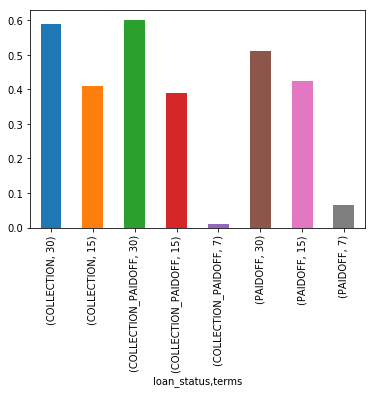

In [26]:
clean_df.groupby('loan_status')['terms'].value_counts(normalize=True).plot.bar()

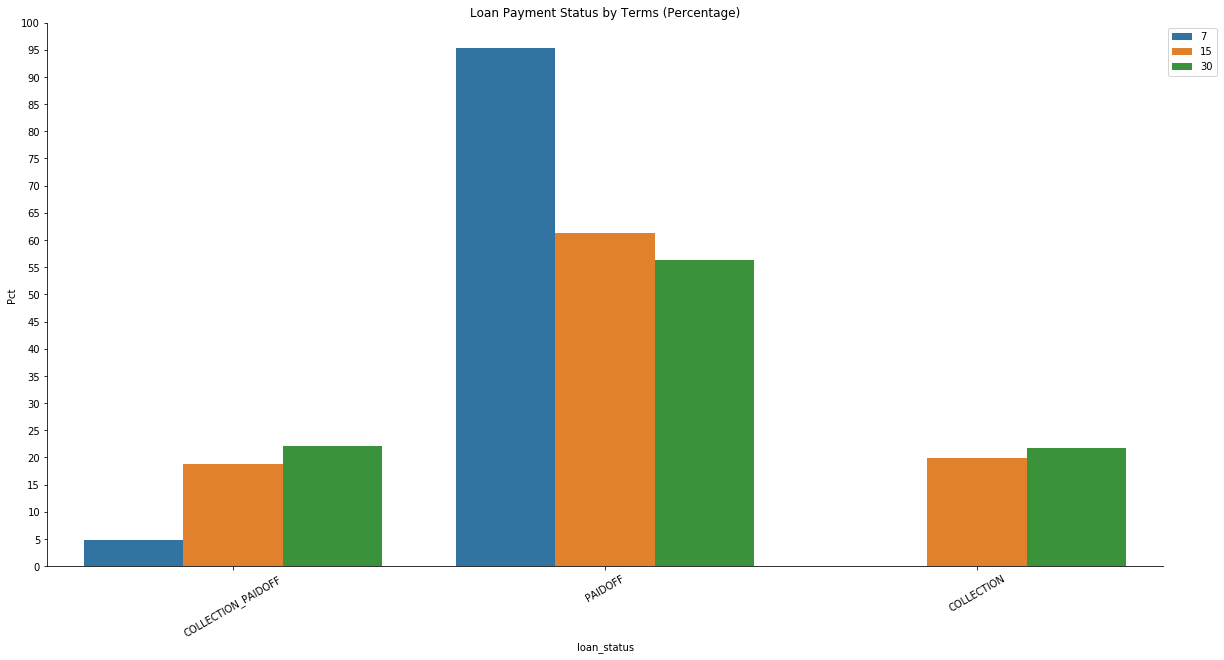

In [27]:
terms_df = clean_df.groupby(['loan_status','terms']).size().reset_index(name='counts')
terms_sum = terms_df.groupby(['terms','loan_status',]).agg({'counts': 'sum'})
terms_pcts = terms_sum.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
terms_pcts.rename({'counts': 'Pct'}, axis=1, inplace=True)

ShowBarPlot(data=terms_pcts, x='loan_status',y='Pct',hue='terms',bins=30, 
           title='Loan Payment Status by Terms (Percentage)',
           rotation=30,figsize_x=20, figsize_y=10)

In [28]:
terms_pcts.head(100)

,terms,loan_status,Pct
0,7,COLLECTION_PAIDOFF,4.761905
1,7,PAIDOFF,95.238095
2,15,COLLECTION,19.806763
3,15,COLLECTION_PAIDOFF,18.840580
4,15,PAIDOFF,61.352657
5,30,COLLECTION,21.691176
6,30,COLLECTION_PAIDOFF,22.058824
7,30,PAIDOFF,56.250000


#### Conclusion for Terms vs. Loan Payment Status Relationship
- people is more likely to payoff short term loan (7 days).
- The longer loan term, the lower payoff rate.

### 3.6 Age Range VS. past_due_days

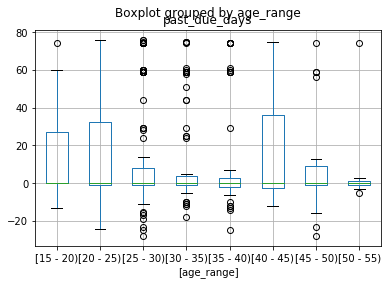

In [29]:
#clean_df.groupby('past_due_days_range')['age_range'].value_counts(normalize=True).plot.bar()

clean_df[['age_range','past_due_days']].boxplot(by='age_range')

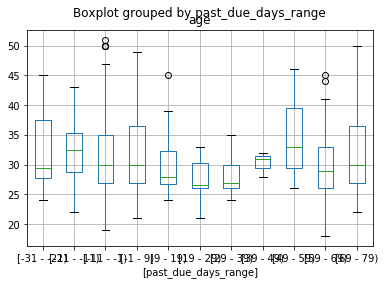

In [30]:
clean_df[['age','past_due_days_range']].boxplot(by='past_due_days_range')

#### Conclusion for Age vs. Past Due Dates Relationship
- People whose age ranges are in 40-45, 20-25, & 15-20 past more due days than other age ranges.
- People whose age range is in 28-37, either pay off the loan in more than 20 days early or past due days about 45 days. This age range people is not reliable.

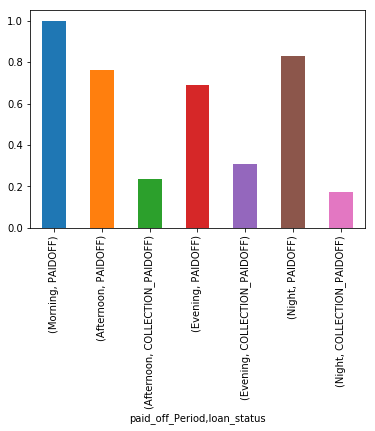

In [38]:
# does the paid off time period matter?
clean_df.groupby('paid_off_Period')['loan_status']\
    .value_counts(normalize=True)\
    .plot.bar()

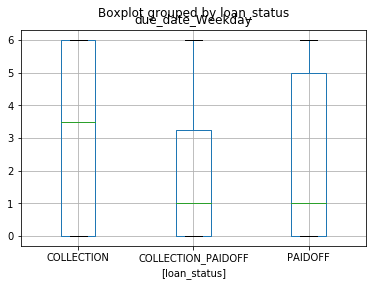

In [36]:
clean_df[['due_date_Weekday','loan_status']].boxplot(by='loan_status')

#### Conclusion
- Due day is more likely to be paid off/collection paid if it's in the beginning week day 
- People more likely paid off loans in the morning

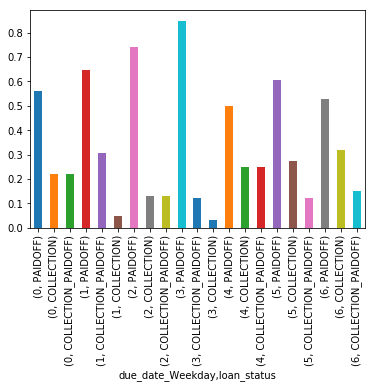

In [37]:
# does the due day of the week matter?
clean_df.groupby('due_date_Weekday')['loan_status']\
    .value_counts(normalize=True)\
    .plot.bar()

# 4. Prediction & Suggestion
### What would help to predict a customer is going to paid off? 

- High education people (College and above)
- Female
- Age range is in 40 - 55
- Short term loan (7 - 15 days)
- Principal is lower (no greater than 900)

### What would help to predict the recovery rate after a loan is in collection (collection_paidoff)? 
- We can cellect paid off past due day less than 10 days.
- Collect loan in the beginning of a week (before Wednesday)
- Don't have time to do further analyzing
- I like to analyze loan terms vs past due date if I have more time.
- Need more data to do machine learning by using stacking model which may include non linear svc, KNeighborsClassifier, GradientBoostingClassifier, RandomForestClassifier,AdaBoostClassifier, K-Means, etc.


### Any suggestions to improve our payoff rate?
- Offer short term loan
- lend loan to college people
- Lend loan to Female
- lend loan to people whose age rang in 40-55.
- Need to analyze due date month since holiday's, seasoning will affect people emotions & behaviors too.


# 5. More Data Variables Will Be Helpful

What else data do you think you want to have to help you better solve those problems above? 

- Is it repeat borrowing
- Regulations on small-dollar credit products have taken different forms in different states, what are the regualtions?
- Historical loan payments to analyze bad/good behaviors 
- Historical credit score for different credit type (like, rental report, Mortgage loans, car loans, student loans, credit cards, etc.) to analyze risk and trend
- Utility Bills
- The region of Borrower’s residence 
    --.	Zip code
    --.	County name
    --. FHFA
- Region median income
- Income/salary range
- whether they are small business owner 
- Whether is house owner
- Owns other debts or loans
- Social networks
    --.	Facebook
    --.	Twitter
- Borrower self-identification:
    --.	race and ethnicity
    --.	Has any illegal record(s)
    --.	Health condition
    --.	Immigration status
    --.	Marriage status
    --.	Has children
- Has car and car insurance
- Has health insurance
